### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la TARGET (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre TARGET).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [647]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
# Preprocess
from sklearn.preprocessing import  OneHotEncoder
from category_encoders import BinaryEncoder

import sys
import importlib
sys.path.append("..")
import config
importlib.reload(config)  # Ensure we get the latest TARGET value
from config import TARGET

In [648]:
# Load the dataset

building_consumption = pd.read_csv("../assets/building_consumption_post_feature_engineering.csv")
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUseTypes,NumberofFloors_quintile,SteamUse,NaturalGas,Electricity,EraBuilt
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,NaN,NaN,249.98,2.83,1,Q5,1,1,1,≤1930
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,NaN,NaN,295.86,2.86,3,Q5,0,1,1,1991-2010
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,NaN,NaN,2089.28,2.19,1,Q5,1,1,1,1951-1970
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,NaN,NaN,286.43,4.67,1,Q5,1,1,1,≤1930
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,NaN,NaN,505.01,2.88,3,Q5,0,1,1,1971-1990


### Suppression des colonnes

In [649]:
### Suppression des colonnes
cols_to_drop = [
    "OSEBuildingID",
    "Comments",
    "DataYear",
    "TaxParcelIdentificationNumber",
    "State",
    "NaturalGas(therms)",
    "Electricity(kWh)",
    "SiteEUI(kBtu/sf)",
    "SiteEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUseWN(kBtu)",
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "GHGEmissionsIntensity",
    "LargestPropertyUseType",
	"LargestPropertyUseTypeGFA",# A checker
    "SecondLargestPropertyUseType",
    "SecondLargestPropertyUseTypeGFA", # A checker
    "ThirdLargestPropertyUseType",
    "ThirdLargestPropertyUseTypeGFA", # A checker
    "YearsENERGYSTARCertified",
    "Outlier",
    "City",
    "PropertyName",
    "Address",
    "Neighborhood",
    "CouncilDistrictCode",
    "Longitude",
    "Latitude",
    "ZipCode",
    "PropertyGFATotal",
]
existing_cols = [col for col in cols_to_drop if col in building_consumption.columns]
building_consumption.drop(columns=existing_cols, inplace=True)
# building_consumption.columns
num_cols = building_consumption.select_dtypes(include="number")
corr_matrix = num_cols.corr()
print(corr_matrix[TARGET].sort_values(ascending=False))

TotalGHGEmissions         1.000000
NumberofBuildings         0.539464
PropertyGFABuilding(s)    0.496896
SteamUse                  0.259737
NaturalGas                0.096858
PropertyGFAParking        0.089392
NumberOfUseTypes          0.041340
Electricity               0.006788
ENERGYSTARScore          -0.081772
Name: TotalGHGEmissions, dtype: float64


#### Matrice de corrélation

TotalGHGEmissions         1.000000
NumberofBuildings         0.539464
PropertyGFABuilding(s)    0.496896
SteamUse                  0.259737
NaturalGas                0.096858
PropertyGFAParking        0.089392
NumberOfUseTypes          0.041340
Electricity               0.006788
ENERGYSTARScore          -0.081772
Name: TotalGHGEmissions, dtype: float64


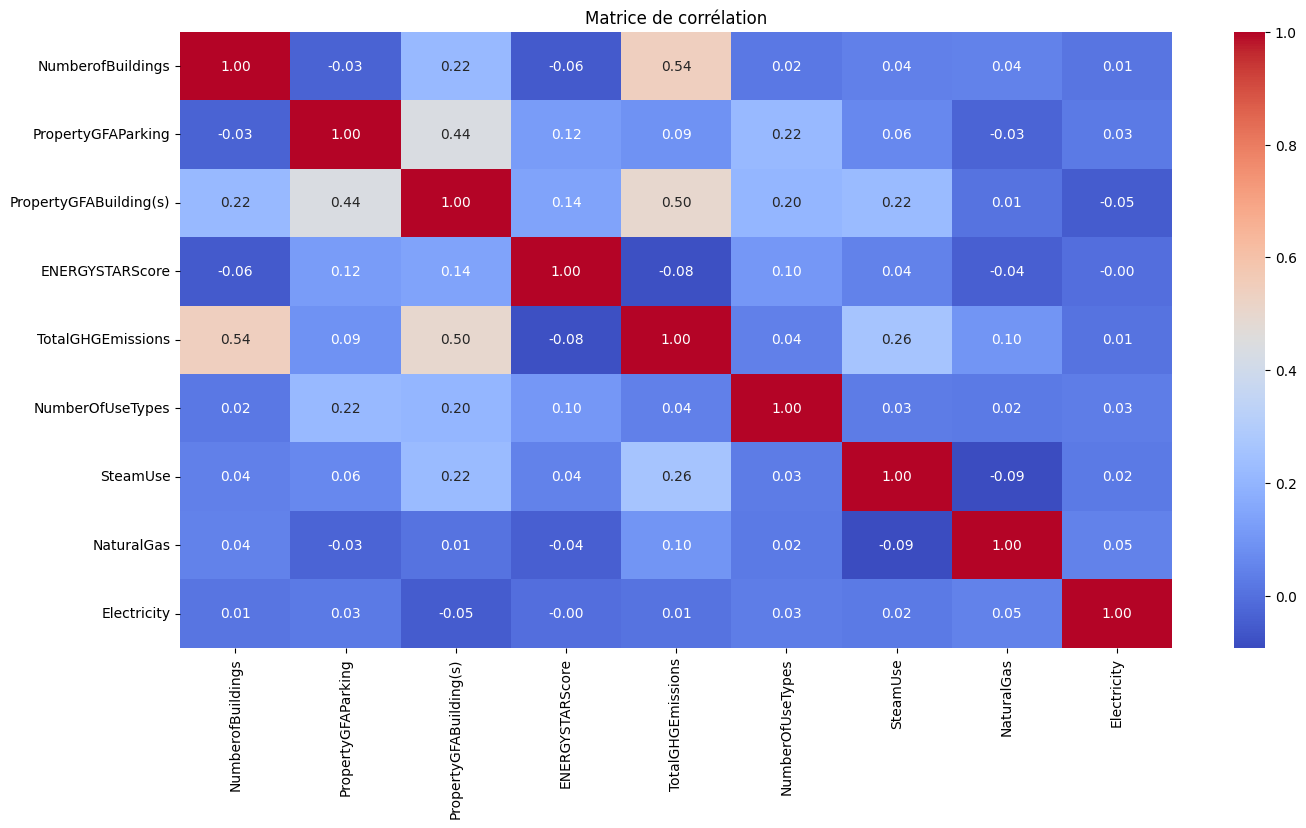

In [650]:
num_cols = building_consumption.select_dtypes(include="number")
corr_matrix = num_cols.corr()
print(corr_matrix[TARGET].sort_values(ascending=False))
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

# Une fois la TARGET choisie, quelles features supprimer ?
# Suppression des features très corrélées avec la TARGET (corr > 0.7) ? > 0 A CONFIRMER
# Ne pas garder à la fois PropertyGFABuilding(s), PropertyGFAParking et PropertyGFATotal ? Supprimer Total ?

### Encodage binaire de la feature PrimaryPropertyType

In [651]:
encoder = BinaryEncoder()
primary_property_type_encoded = encoder.fit_transform(
	building_consumption[["PrimaryPropertyType"]]
)
primary_property_type_encoded.shape
building_consumption = pd.concat(
    [building_consumption, primary_property_type_encoded], axis=1  # type: ignore
)
building_consumption.drop(columns=["PrimaryPropertyType"], inplace=True)
building_consumption.head()

,BuildingType,NumberofBuildings,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,TotalGHGEmissions,NumberOfUseTypes,NumberofFloors_quintile,SteamUse,NaturalGas,Electricity,EraBuilt,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4
0,NonResidential,1.0,0,88434,60.0,249.98,1,Q5,1,1,1,≤1930,0,0,0,0,1
1,NonResidential,1.0,15064,88502,61.0,295.86,3,Q5,0,1,1,1991-2010,0,0,0,0,1
2,NonResidential,1.0,196718,759392,43.0,2089.28,1,Q5,1,1,1,1951-1970,0,0,0,0,1
3,NonResidential,1.0,0,61320,56.0,286.43,1,Q5,1,1,1,≤1930,0,0,0,0,1
4,NonResidential,1.0,62000,113580,75.0,505.01,3,Q5,0,1,1,1971-1990,0,0,0,0,1


### One-hot encoding

In [652]:
# Features à encoder
features_to_encode = ["BuildingType", "NumberofFloors_quintile", "EraBuilt"]

In [653]:
for feature in features_to_encode : 
	print(building_consumption[feature].nunique())
	print(building_consumption[feature].value_counts())

4
BuildingType
NonResidential        1434
Nonresidential COS      81
SPS-District K-12       23
Nonresidential WA        1
Name: count, dtype: int64
5
NumberofFloors_quintile
Q1    440
Q2    344
Q5    273
Q3    244
Q4    238
Name: count, dtype: int64
6
EraBuilt
≤1930        398
1951-1970    378
1971-1990    307
1991-2010    304
1931-1950    104
Post-2010     48
Name: count, dtype: int64


In [654]:
enc = OneHotEncoder(sparse_output=False, drop="first")

for feature in features_to_encode:
    # Fit + transform
    encoded_cat = enc.fit_transform(building_consumption[[feature]])

    # Récupérer les noms des colonnes encodées
    encoded_df = pd.DataFrame(
        encoded_cat,
        columns=enc.get_feature_names_out([feature]),
        index=building_consumption.index,  # 🔑 garder les bons index
    )

    # Concatener avec le dataset
    building_consumption = pd.concat([building_consumption, encoded_df], axis=1)

    # Supprimer l’ancienne colonne
    building_consumption.drop(columns=[feature], inplace=True)

building_consumption.head()

,NumberofBuildings,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,TotalGHGEmissions,NumberOfUseTypes,SteamUse,NaturalGas,Electricity,PrimaryPropertyType_0,...,BuildingType_SPS-District K-12,NumberofFloors_quintile_Q2,NumberofFloors_quintile_Q3,NumberofFloors_quintile_Q4,NumberofFloors_quintile_Q5,EraBuilt_1951-1970,EraBuilt_1971-1990,EraBuilt_1991-2010,EraBuilt_Post-2010,EraBuilt_≤1930
0,1.0,0,88434,60.0,249.98,1,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,15064,88502,61.0,295.86,3,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,196718,759392,43.0,2089.28,1,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0,61320,56.0,286.43,1,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,62000,113580,75.0,505.01,3,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [655]:
# Identifier les features catégorielles
cat_cols = building_consumption.select_dtypes(include="object").columns.tolist()
print("Colonnes catégorielles :", cat_cols)

Colonnes catégorielles : []


Skewness de TotalGHGEmissions : 13.91
Kurtosis de TotalGHGEmissions : 245.21


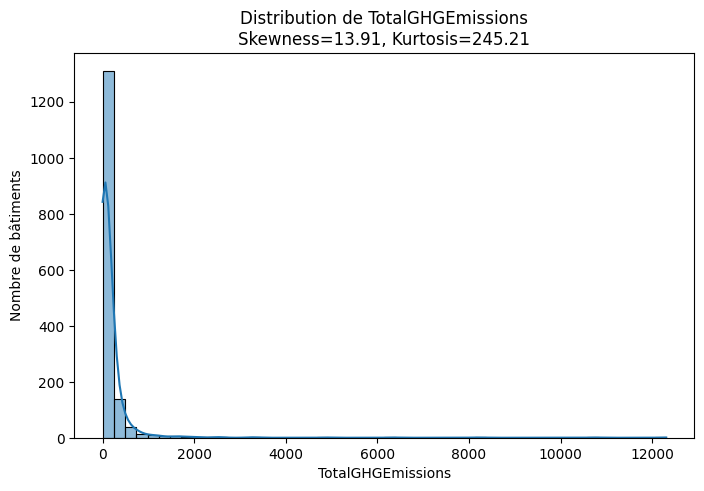

In [656]:
# Calcul skewness et kurtosis
skewness = building_consumption[TARGET].skew()
kurtosis = building_consumption[TARGET].kurt()

print(f"Skewness de {TARGET} : {skewness:.2f}")
print(f"Kurtosis de {TARGET} : {kurtosis:.2f}")

# Histogramme
plt.figure(figsize=(8, 5))
sns.histplot(building_consumption[TARGET], bins=50, kde=True)
plt.title(f"Distribution de {TARGET}\nSkewness={skewness:.2f}, Kurtosis={kurtosis:.2f}")
plt.xlabel(TARGET)
plt.ylabel("Nombre de bâtiments")
plt.show()

In [657]:
# Identification des items sans données concernant les émissions de GES, puis suppression
building_consumption[building_consumption[TARGET].isna()]
building_consumption = building_consumption[~building_consumption[TARGET].isna()]
print(
    "Nombre de bâtiments restants (après suppression des NaN) :",
    building_consumption.shape[0],
)

Nombre de bâtiments restants (après suppression des NaN) : 1539


### Identification des outliers (z-score > 3)

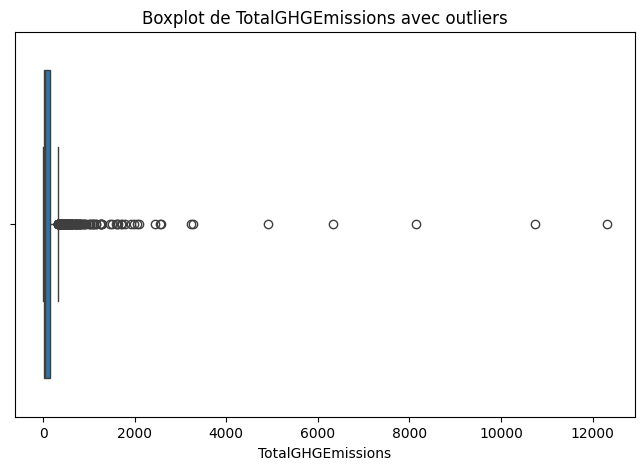

In [658]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=building_consumption[TARGET])
plt.title(f"Boxplot de {TARGET} avec outliers")
plt.show()

#### Z-score

In [659]:
z_score_feature = "PropertyGFABuilding(s)"

# Série avec NaN gérés
series = building_consumption[z_score_feature]

# Calcul des Z-scores uniquement sur valeurs valides
z_scores = stats.zscore(series.dropna())

# Créer une Series bien indexée
z_scores = pd.Series(z_scores, index=series.dropna().index)

# Sélectionner les outliers
outlier_idx = z_scores[z_scores.abs() > 3].index
outliers_z = building_consumption.loc[outlier_idx, z_score_feature]

# Résumé
n_outliers = len(outliers_z)
pct_outliers = n_outliers / building_consumption.shape[0] * 100

print(f"Nombre d'outliers (Z-score) : {n_outliers}")
print(f"% d'outliers par rapport au dataset total : {pct_outliers:.2f}%")

# Détails complets
outliers_details = building_consumption.loc[outlier_idx]
display(outliers_details.sort_values(by=z_score_feature, ascending=False).head(10))

Nombre d'outliers (Z-score) : 35
% d'outliers par rapport au dataset total : 2.27%


,NumberofBuildings,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,TotalGHGEmissions,NumberOfUseTypes,SteamUse,NaturalGas,Electricity,PrimaryPropertyType_0,...,BuildingType_SPS-District K-12,NumberofFloors_quintile_Q2,NumberofFloors_quintile_Q3,NumberofFloors_quintile_Q4,NumberofFloors_quintile_Q5,EraBuilt_1951-1970,EraBuilt_1971-1990,EraBuilt_1991-2010,EraBuilt_Post-2010,EraBuilt_≤1930
559,7.0,0,1765970,54.0,12307.16,2,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
501,1.0,319400,1632820,86.0,882.56,2,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
436,1.0,0,1592914,97.0,481.06,5,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
255,1.0,0,1400000,NaN,0.00,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
424,1.0,0,1380959,79.0,810.70,3,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
176,1.0,0,1323055,94.0,318.97,3,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
127,1.0,327680,1258280,NaN,892.63,2,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
244,1.0,389860,1215718,97.0,525.78,3,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
187,1.0,159600,1195387,89.0,429.27,2,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
130,1.0,0,1172127,NaN,1246.55,1,0,1,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [660]:
# Si besoin d'inspecter un bâtiment en particulier
building_consumption.loc[596]

NumberofBuildings                      1.00
PropertyGFAParking                     0.00
PropertyGFABuilding(s)             33589.00
ENERGYSTARScore                       90.00
TotalGHGEmissions                     21.93
NumberOfUseTypes                       1.00
SteamUse                               0.00
NaturalGas                             1.00
Electricity                            1.00
PrimaryPropertyType_0                  1.00
PrimaryPropertyType_1                  0.00
PrimaryPropertyType_2                  0.00
PrimaryPropertyType_3                  0.00
PrimaryPropertyType_4                  0.00
BuildingType_Nonresidential COS        0.00
BuildingType_Nonresidential WA         0.00
BuildingType_SPS-District K-12         0.00
NumberofFloors_quintile_Q2             1.00
NumberofFloors_quintile_Q3             0.00
NumberofFloors_quintile_Q4             0.00
NumberofFloors_quintile_Q5             0.00
EraBuilt_1951-1970                     0.00
EraBuilt_1971-1990              

#### IQR

Nombre d'outliers (IQR) : 164
% d'outliers par rapport au dataset total : 10.66%


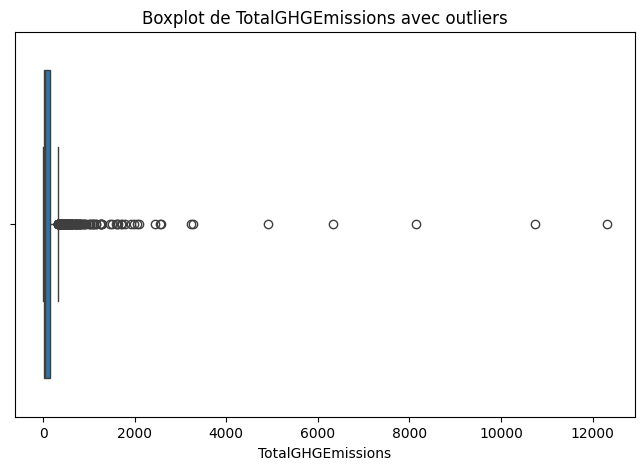

In [661]:
Q1 = building_consumption[TARGET].quantile(0.25)
Q3 = building_consumption[TARGET].quantile(0.75)
IQR = Q3 - Q1

# Bornes
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# Outliers (hors bornes)
outliers_iqr = building_consumption.loc[
    (building_consumption[TARGET] < borne_inf)
    | (building_consumption[TARGET] > borne_sup),
    TARGET,
]

print(f"Nombre d'outliers (IQR) : {len(outliers_iqr)}")
print(
    "% d'outliers par rapport au dataset total : {:.2f}%".format(
        len(outliers_iqr) / building_consumption.shape[0] * 100
    )
)
outliers_iqr.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.boxplot(x=building_consumption[TARGET])
plt.title(f"Boxplot de {TARGET} avec outliers")
plt.show()

### Nettoyage des valeurs manquantes

In [662]:
# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
missing_values = building_consumption.isnull().sum()
missing_features = missing_values[missing_values > 0]
print(missing_features)

if len(missing_features) > 0:
    print(f"\nNombre total de valeurs manquantes : {missing_values.sum()}")
    print(f"Pourcentage de valeurs manquantes : {(missing_values.sum() / building_consumption.size) * 100:.2f}%")
else:
    print("Aucune valeur manquante détectée.")
    
print(f"\nShape avant nettoyage : {building_consumption.shape}")

Valeurs manquantes par colonne :
ENERGYSTARScore    547
dtype: int64

Nombre total de valeurs manquantes : 547
Pourcentage de valeurs manquantes : 1.37%

Shape avant nettoyage : (1539, 26)


In [663]:
# Pour les features de surface, remplacer les NaN par 0
# surface_features = ["ThirdLargestPropertyUseTypeGFA"]
# building_consumption[surface_features] = building_consumption[surface_features].fillna(0)

In [664]:
# Pour ENERGYSTARScore : pas besoin d'effectuer une imputation par la médiane (score énergétique) car le score médian dans la définition est de 50

building_consumption.loc[
    building_consumption["ENERGYSTARScore"].isna(), "ENERGYSTARScore"
] = 50


# Vérification finale
total_missing_after = building_consumption.isnull().sum().sum()
print(f"\nNombre total de valeurs manquantes après nettoyage : {total_missing_after}")
print(f"Shape après nettoyage : {building_consumption.shape}")


Nombre total de valeurs manquantes après nettoyage : 0
Shape après nettoyage : (1539, 26)


### Log Transformation sur les surfaces

In [665]:
for col in [
    # "LargestPropertyUseTypeGFA",
    # "SecondLargestPropertyUseTypeGFA",
    # "ThirdLargestPropertyUseTypeGFA",
    "PropertyGFABuilding(s)",
    "PropertyGFAParking",
]:
    building_consumption[col] = building_consumption[col].apply(lambda x: np.log1p(x))

In [666]:
### Dataset final nettoyé
building_consumption.to_csv(
    "../assets/building_consumption_cleaned.csv", index=False
)
print(f"Dataset sauvegardé avec {building_consumption.shape[0]} lignes et {building_consumption.shape[1]} colonnes")
print("Aucune valeur manquante restante")

Dataset sauvegardé avec 1539 lignes et 26 colonnes
Aucune valeur manquante restante
